In [1]:
from annoy import AnnoyIndex
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import torch

# Load the dataset from the relative directory
print("Loading dataset from disk...")
ds = load_dataset("wikimedia/wikipedia", "20231101.en")
print("Dataset loaded successfully!")

# Load the SentenceTransformer model
print("Loading SentenceTransformer model...")
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print("Model loaded successfully!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# Initialize variables
num_parts = 10  # Number of parts to divide the dataset
f = model.get_sentence_embedding_dimension()  # Dimension of embeddings
output_dir = "annoy_indexes"  # Directory to save Annoy files

# Split the dataset
texts = ds['train']['text'][:5000]

C:\Users\konrad_master\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset from disk...
Dataset loaded successfully!
Loading SentenceTransformer model...
Model loaded successfully!
Using device: cuda


In [2]:
texts = ds['train']['text'][:10000]

Embedding text parts: 100%|██████████| 5000/5000 [08:10<00:00, 10.20it/s]


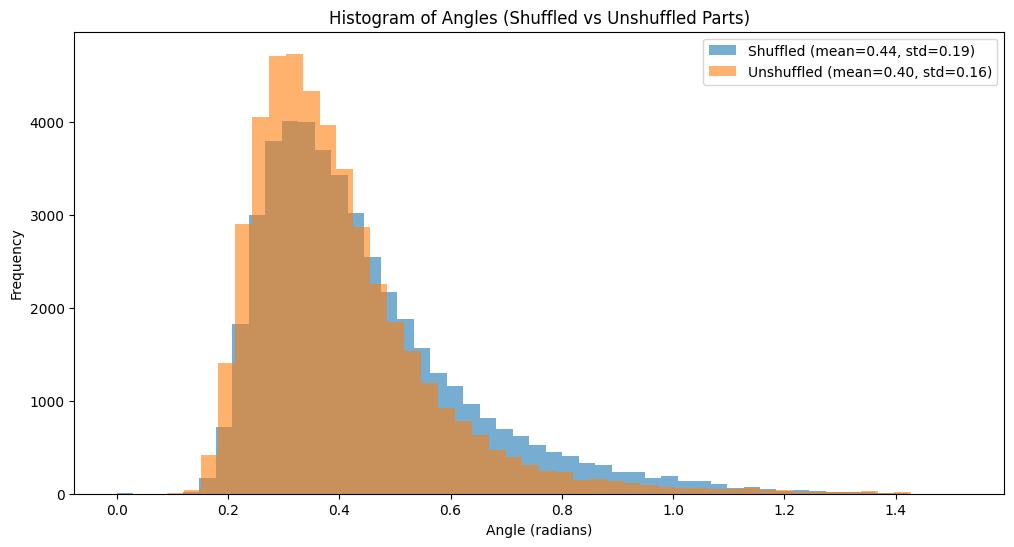

In [4]:
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Helper function to divide a text into n parts
def split_text_into_parts(text, n):
    words = text.split()
    avg = len(words) // n # Base size of each part
    parts = [words[i * avg:(i + 1) * avg] for i in range(n)]
    return [" ".join(part) for part in parts]

def split_text_into_parts_with_overlap(text, n, overlap):
    words = text.split()
    avg = len(words) // n
    total_words = len(words)
    avg = total_words // n  # Base size of each part
    overlap_size = int(overlap * avg)  # Number of overlapping words
    #arts = [words[i * avg - int((i>0)*overlap*avg):(i + 1) * avg + int((i<n-1)*overlap*avg)] for i in range(n)]
    parts = []
    for i in range(n):
        start = max(0, i * avg - overlap_size * (i > 0))
        end = min(total_words, (i + 1) * avg + overlap_size * (i < n - 1))
        parts.append(" ".join(words[start:end]))
    return [" ".join(part) for part in parts]

# Shuffle parts of text
def shuffle_text_parts(parts):
    random.shuffle(parts)
    return parts

# Embed text parts using the model
def embed_texts(model, device, texts_parts):
    embeddings = []
    for parts in tqdm(texts_parts, desc="Embedding text parts"):
        embeddings.append([model.encode(part, device=device) for part in parts])
    return embeddings

# Calculate cosine distances between sequential parts
def calculate_distances(embeddings):
    distances = []
    for doc_embeddings in embeddings:
        for i in range(len(doc_embeddings) - 1):
            cosine_similarity = np.dot(doc_embeddings[i], doc_embeddings[i + 1]) / (
                np.linalg.norm(doc_embeddings[i]) * np.linalg.norm(doc_embeddings[i + 1])
            )
            angle = np.arccos(np.clip(cosine_similarity, -1, 1))
            distances.append(abs(angle))
    return distances

# Parameters
#n_parts = 10  # Number of parts per document
n_parts = 10
num_texts = len(texts) // 2

# Process first half: shuffle parts
#texts_shuffled = [shuffle_text_parts(split_text_into_parts(text, n_parts)) for text in texts[:num_texts]]
texts_shuffled = [shuffle_text_parts(split_text_into_parts_with_overlap(text, n_parts, 0.4)) for text in texts[:num_texts]]
texts_shuffled_embeddings = embed_texts(model, device, texts_shuffled)
shuffled_angles = calculate_distances(texts_shuffled_embeddings)

# Process second half: no shuffle
#texts_unshuffled = [split_text_into_parts(text, n_parts) for text in texts[num_texts:]]
texts_unshuffled = [split_text_into_parts_with_overlap(text, n_parts, 0.4) for text in texts[:num_texts]] #note: I changed it to :num_texts for comparability
texts_unshuffled_embeddings = embed_texts(model, device, texts_unshuffled) #so effectively only half of the text is considered
unshuffled_angles = calculate_distances(texts_unshuffled_embeddings)


# Calculate mean and standard deviation
shuffled_mean = np.mean(shuffled_angles)
shuffled_std = np.std(shuffled_angles)
unshuffled_mean = np.mean(unshuffled_angles)
unshuffled_std = np.std(unshuffled_angles)

# Plot histograms
plt.figure(figsize=(12, 6), label=f'Text splits = {n_parts}')
plt.hist(shuffled_angles, bins=50, alpha=0.6, label=f'Shuffled (mean={shuffled_mean:.2f}, std={shuffled_std:.2f})')
plt.hist(unshuffled_angles, bins=50, alpha=0.6, label=f'Unshuffled (mean={unshuffled_mean:.2f}, std={unshuffled_std:.2f})')
plt.xlabel("Angle (radians)")
plt.ylabel("Frequency")
plt.title("Histogram of Angles (Shuffled vs Unshuffled Parts)")
plt.legend()
plt.show()

Model loaded successfully!
Embedding Wikipedia dataset...


Batches: 100%|██████████| 157/157 [00:14<00:00, 11.08it/s]


Embedding Reddit dataset...


Batches: 100%|██████████| 157/157 [00:03<00:00, 48.16it/s]


Performing PCA...
Wikipedia Mean: [-1.05885789e-02 -1.74894126e-03 -2.64213048e-02 -2.83602276e-03
 -1.33003388e-02 -3.54775880e-03  8.07122793e-03  1.78115647e-02
  2.67236354e-03  1.33715163e-03 -3.41561507e-03 -1.39092254e-02
  8.66245758e-03  9.74977098e-04 -9.96450242e-03  2.54464964e-03
 -8.45876150e-03 -3.26438132e-03 -7.53985438e-03  6.55783387e-03
  5.34900837e-03 -1.53127534e-04  2.26912275e-03 -9.54424031e-03
  3.39630363e-03  3.30835721e-03 -7.74897309e-03 -3.55886342e-03
 -1.35349547e-02  1.62612728e-03  4.43771528e-03 -1.95910293e-03
  8.13040789e-03  5.91209042e-04 -5.67839528e-03  1.39966551e-02
  9.07043647e-03  1.34672439e-02 -7.36597367e-03  4.99846088e-03
 -8.06428399e-03  3.86062963e-03 -1.26497038e-02  6.61819894e-03
 -9.00250580e-03  3.38325812e-03 -5.90648997e-05  4.50412277e-03
 -1.37067623e-02  5.54436818e-03 -4.85401973e-03 -7.97378179e-03
  3.38711007e-03  5.38616721e-03  4.17695474e-03 -8.31521768e-03
 -1.24982577e-02  2.36505456e-03 -6.50048535e-03 -7.2648

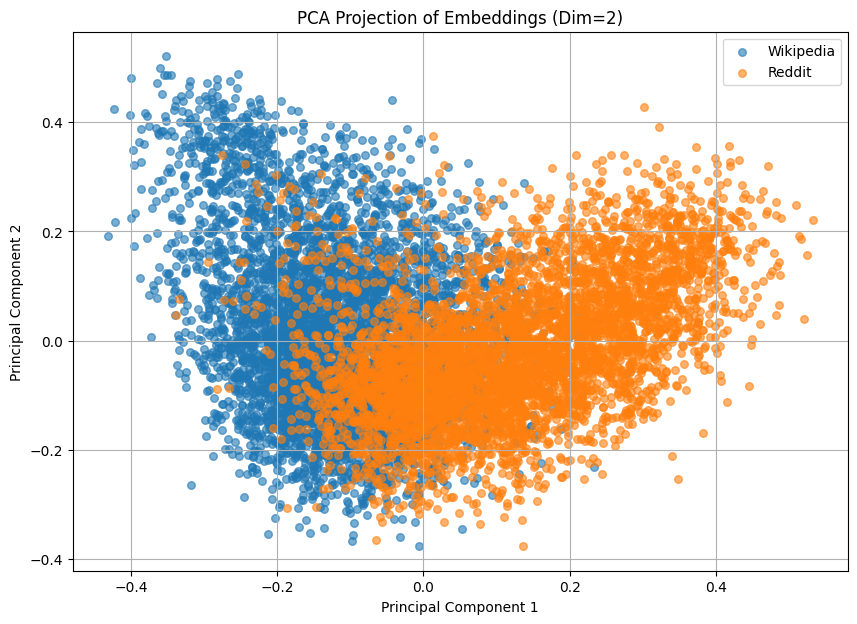

In [18]:

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

ds_wikipedia = load_dataset("wikimedia/wikipedia", "20231101.en", split="train[:5000]")
ds_reddit = load_dataset("launch/reddit_qg", split="train[:5000]")

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print("Model loaded successfully!")

# Embed documents from both datasets
print("Embedding Wikipedia dataset...")
wikipedia_embeddings = model.encode(ds_wikipedia['text'], show_progress_bar=True)

print("Embedding Reddit dataset...")
reddit_embeddings = model.encode(ds_reddit['answer'], show_progress_bar=True)

# Perform PCA to reduce dimensions to 2
print("Performing PCA...")
pca = PCA(n_components=2)
all_embeddings = np.vstack([wikipedia_embeddings, reddit_embeddings])
reduced_embeddings = pca.fit_transform(all_embeddings)

# Split reduced embeddings back into separate datasets
reduced_wikipedia = reduced_embeddings[:len(wikipedia_embeddings)]
reduced_reddit = reduced_embeddings[len(wikipedia_embeddings):]

# Calculate centers, means, and standard deviations for each dataset
wikipedia_mean = np.mean(wikipedia_embeddings, axis=0)
wikipedia_std = np.std(wikipedia_embeddings, axis=0)

reddit_mean = np.mean(reddit_embeddings, axis=0)
reddit_std = np.std(reddit_embeddings, axis=0)

# Print the mean and std for each dataset
print("Wikipedia Mean:", wikipedia_mean)
print("Wikipedia Std Dev:", wikipedia_std)
print("Reddit Mean:", reddit_mean)
print("Reddit Std Dev:", reddit_std)

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(reduced_wikipedia[:, 0], reduced_wikipedia[:, 1], alpha=0.6, label='Wikipedia', s=30)
plt.scatter(reduced_reddit[:, 0], reduced_reddit[:, 1], alpha=0.6, label='Reddit', s=30)
plt.legend()
plt.title("PCA Projection of Embeddings (Dim=2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

In [20]:
from scipy.spatial.distance import cdist

# Compute the distance of each Reddit embedding from the Wikipedia mean
distances = cdist(reddit_embeddings, [wikipedia_mean], metric='euclidean').flatten()

# Find the index of the farthest Reddit embedding
farthest_index = np.argmax(distances)
farthest_distance = distances[farthest_index]

# Get the corresponding Reddit message
farthest_message = ds_reddit['answer'][farthest_index]

# Output the result
print(f"The Reddit message farthest from the Wikipedia mean is:\n{farthest_message}")
print(f"Distance from the Wikipedia mean: {farthest_distance}")

closest_index = np.argmin(distances)
closest_distance = distances[closest_index]

# Get the corresponding Reddit message
closest_message = ds_reddit['answer'][closest_index]

# Output the result
print(f"The Reddit message farthest from the Wikipedia mean is:\n{closest_message}")
print(f"Distance from the Wikipedia mean: {closest_distance}")

The Reddit message farthest from the Wikipedia mean is:
The studio normally will file a loss if the movie doesn't make up the difference within a given period of time, but the problem is most movies do make their production budget back well before that time passes, thanks to the home video market
Distance from the Wikipedia mean: 1.0508451168848965
The Reddit message farthest from the Wikipedia mean is:
I'm going to recommend People and Identity in Ostrogothic Italy by Patrick Amory. It should give you at least some picture of Germanic ethnic identities existing alongside Roman ones. Your actual question is incredibly vague. What was an immigration like? Any answer would have to be very very broad, and writers at the time didn't worry so much about the details of cultural assimilation. Today, we understand that ethnic identity is fluid, and that means we have peoples who are in some nebulous state between Germanic tribe and romanized polity that is still distinct from the empire. The V